In [1]:
from dtw import accelerated_dtw 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [49]:
patient_0 = pd.read_parquet('data/patient_0.gzip')

In [50]:
patient_0.columns

Index(['chan 1', 'chan 2', 'chan 3', 'Time', 'Lefteye', 'RightEye', 'EMG',
       'C3A2', 'C4A1', 'ECG', 'SpO2', 'Sound', 'Flow', 'Sum', 'ribcage',
       'abdo', 'BodyPos', 'Pulse'],
      dtype='object')

In [51]:
manhattan_distance = lambda x, y: np.abs(x - y)
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(patient_0['ECG'].to_numpy(), patient_0['Pulse'].to_numpy(), dist=manhattan_distance)

MemoryError: Unable to allocate 90.4 TiB for an array with shape (3525121, 3525121) and data type float64

Note, DTW is not possible due to space limitations.

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
adfuller(patient_0['Pulse'])

: 

adfuller did not work either.

Main analysis of the project

In [2]:
subject_data = pd.read_excel('SubjectDetails.xls')
# dtw_data = pd.read_csv('DTW_results.csv')

In [3]:
dtw_data = pd.DataFrame(columns=['Patient', 'DTW: Pulse - BodyPos', 'DTW: Pulse - ECG', 'DTW: Pulse - EMG', 'DTW: Pulse - SpO2'])
files = sorted(os.listdir('DTW_standardized'))
for i, f in enumerate(files):
    patient_matrix = pd.read_csv(f'DTW_standardized/{f}', index_col=0)
    dtw_data.loc[i] = [i, *patient_matrix.loc['Pulse', ['BodyPos', 'ECG', 'EMG', 'SpO2']].tolist()]

In [4]:
# Merge data frames
df = pd.concat([subject_data, dtw_data], axis=1)

In [5]:
# Groups of interest
# Age, divided in 3 groups, use the 1/3, 2/3, and 1 quantiles to calculate each group's threshold.
# BMI, groups divided similarly as age
# Gender, males and females
age_quantiles = df['Age'].quantile([1/3, 2/3, 1])
df['Age_Group'] = df['Age'].transform(lambda x: 'G1' if x <= age_quantiles.iloc[0] else 'G2' if x <= age_quantiles.iloc[1] else 'G3')

bmi_quantiles = df['BMI'].quantile([1/3, 2/3, 1])
df['BMI_Group'] = df['BMI'].transform(lambda x: 'G1' if x <= bmi_quantiles.iloc[0] else 'G2' if x <= bmi_quantiles.iloc[1] else 'G3')

In [6]:
groups = ['Age_Group', 'BMI_Group', 'Gender']
cols = ['DTW: Pulse - BodyPos', 'DTW: Pulse - ECG', 'DTW: Pulse - EMG', 'DTW: Pulse - SpO2']
groups_labels = {'Age_Group':{'G1': f'Age $\leq$ {age_quantiles.iloc[0]}', 'G2': f'{age_quantiles.iloc[0]} < Age $\leq$ {age_quantiles.iloc[1]}', 'G3': f'Age > {age_quantiles.iloc[1]}'},
                 'BMI_Group':{'G1': f'BMI $\leq$ {bmi_quantiles.iloc[0]}', 'G2': f'{bmi_quantiles.iloc[0]} < BMI $\leq$ {bmi_quantiles.iloc[1]}', 'G3': f'BMI > {bmi_quantiles.iloc[1]}'},
                 'Gender':{'M':'Male', 'F': 'Female'}}
seaborn_themes = ['seismic', 'autumn', 'gist_stern']

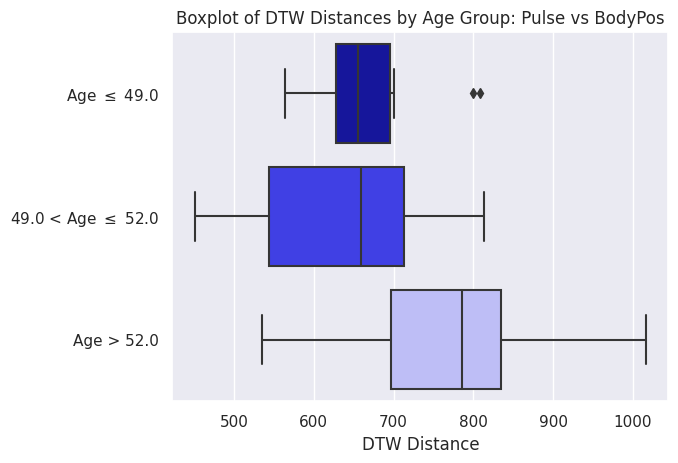

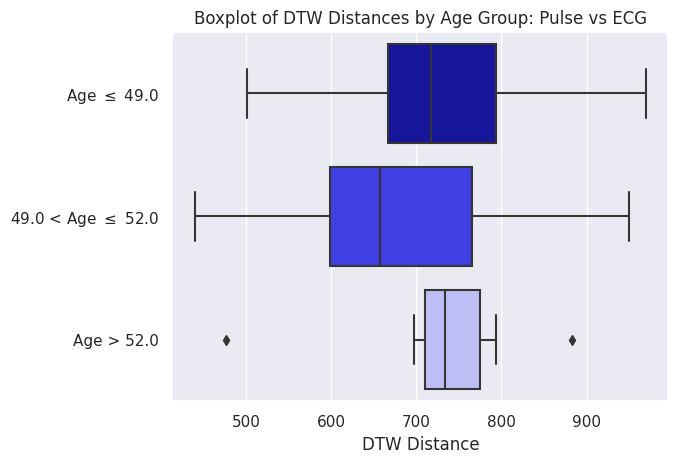

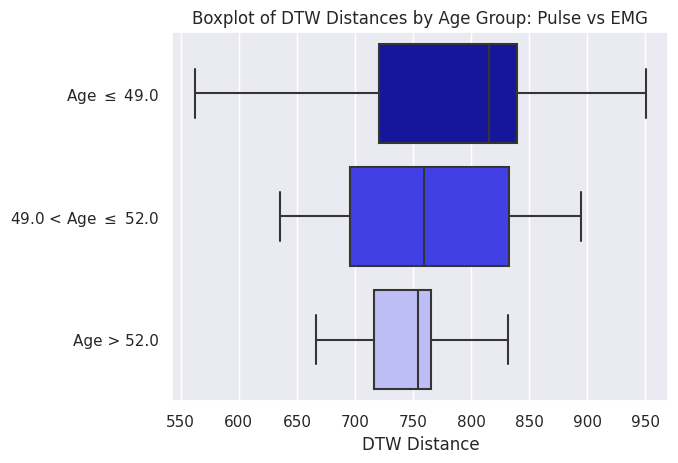

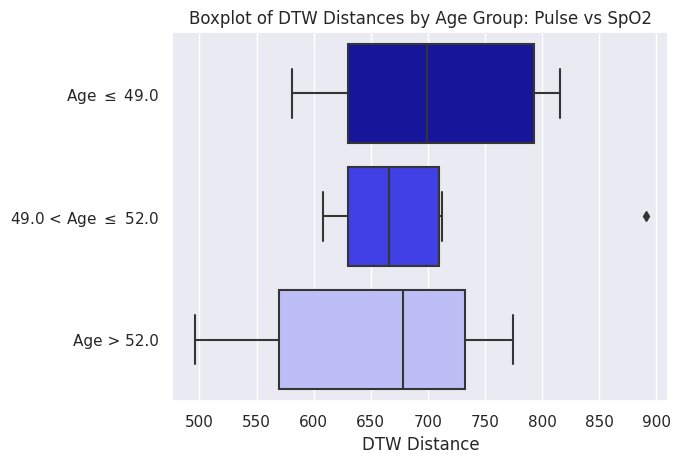

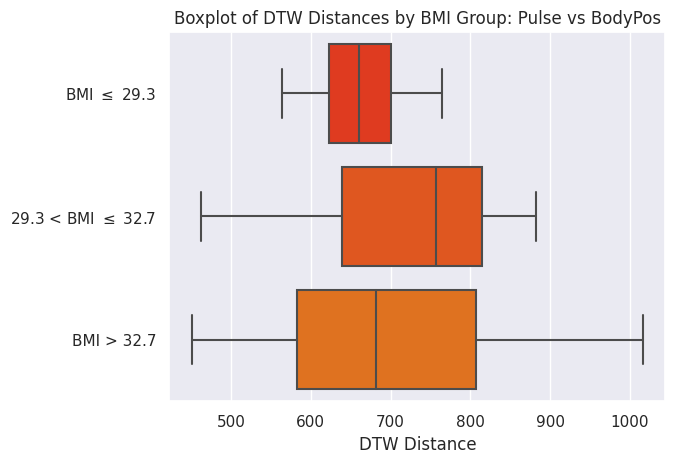

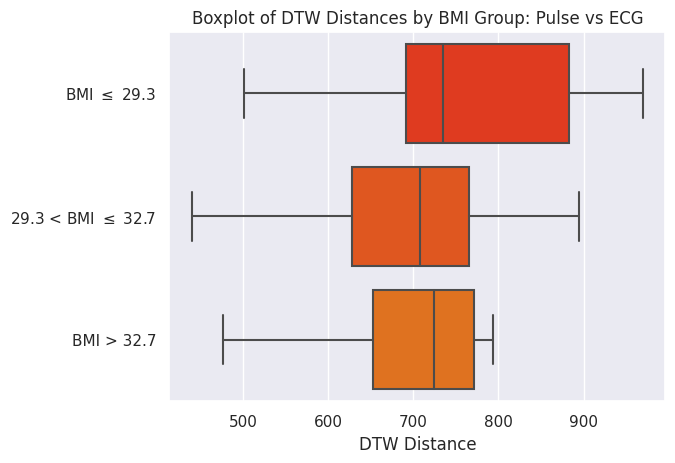

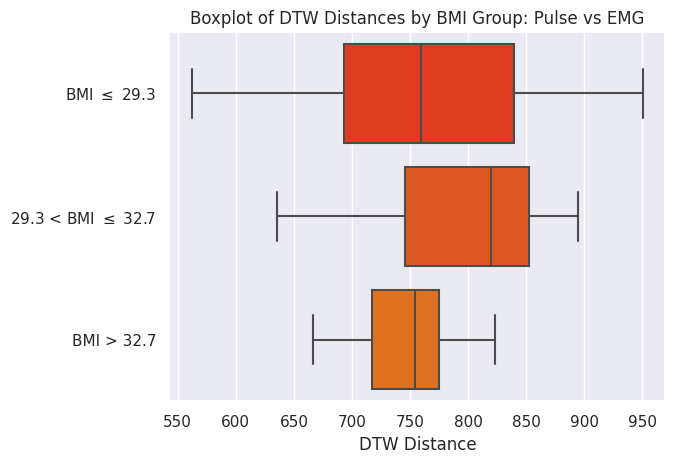

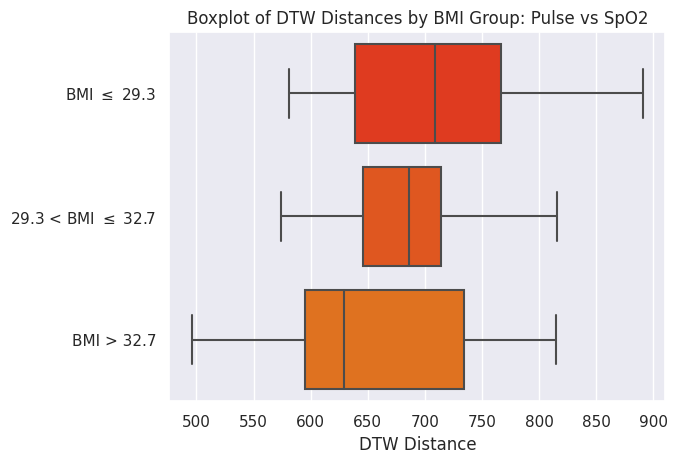

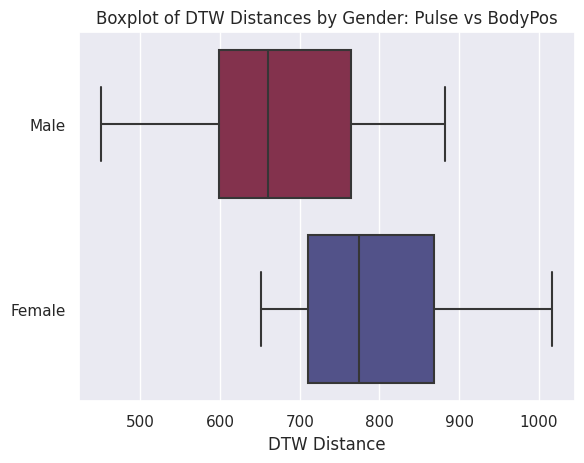

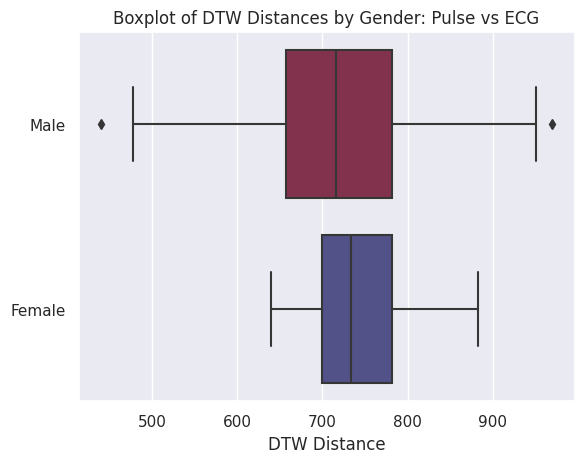

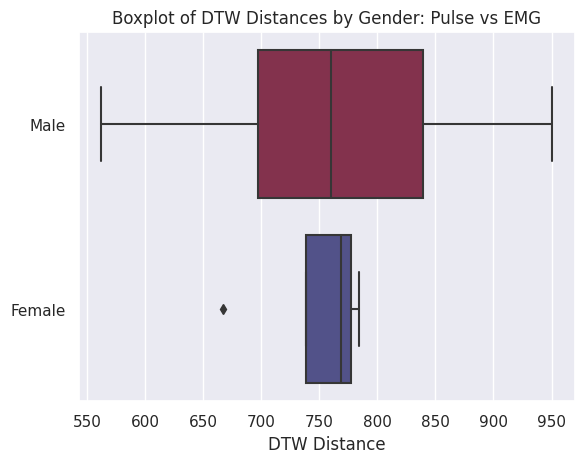

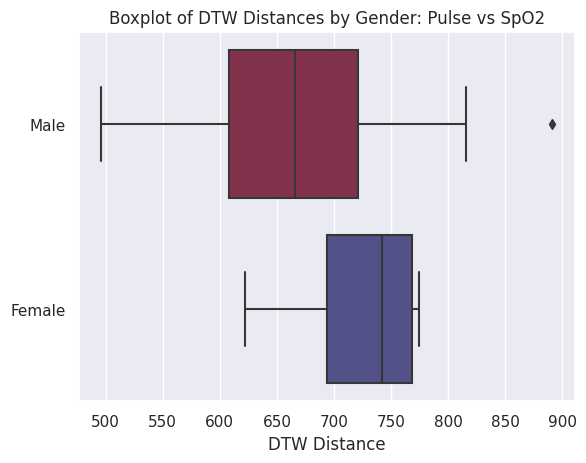

In [7]:
for k, g in enumerate(groups):
    sns.set_theme(palette=seaborn_themes[k])
    for c in cols:
        # Make main plot
        ax = sns.boxplot(df, x=c, y = g, order=groups_labels[g].keys())

        # Change labels
        ax.set_title(f'Boxplot of DTW Distances by {" ".join(g.split("_"))}: ' + c[5:].replace('-', 'vs'))
        ax.set_xlabel('DTW Distance')
        ax.set_ylabel(None)
        ax.set_yticklabels([groups_labels[g][label] for label in [i.get_text() for i in ax.get_yticklabels()]])

        # Display figure
        fig = ax.get_figure()
        plt.close(fig)
        display(fig)